In [ ]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.optim import Adam
from torch.utils.data import DataLoader
import os

from PIL import Image
import torch.nn.functional as F


num = 100_000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, v2, Resize, Normalize
import matplotlib.pyplot as plt
import numpy as np

H,W = 120,98

transform = v2.Compose([
    ToTensor(),
    v2.ToDtype(torch.float32),
    Resize(size=(H,W)),
    Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5]) 
])

In [ ]:
images= os.listdir("/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba")
training_data = torch.zeros((num, 3, H, W), dtype=torch.float32)
for i, img in enumerate(images[:num]):
    if i % 5000 == 0:
        print(i)
    training_data[i] = transform(Image.open("/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/"+img).convert('RGB'))

In [4]:
training_data.shape

torch.Size([100000, 3, 120, 98])

In [5]:
data = DataLoader(training_data, batch_size=32, shuffle=True)


In [6]:
T = 1000
betas = torch.linspace(0.0001, 0.02, T)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, 0, dtype=torch.float64)

In [7]:
import math

def positionalencoding2d(d_model, height, width):
    """
    :param d_model: dimension of the model
    :param height: height of the positions
    :param width: width of the positions
    :return: d_model*height*width position matrix
    """
    if d_model % 4 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dimension (got dim={:d})".format(d_model))
    pe = torch.zeros(d_model, height, width)
    # Each dimension use half of d_model
    d_model = int(d_model / 2)
    div_term = torch.exp(torch.arange(0., d_model, 2) *
                         -(math.log(10000.0) / d_model))
    pos_w = torch.arange(0., width).unsqueeze(1)
    pos_h = torch.arange(0., height).unsqueeze(1)
    pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
    pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)

    return pe


embeddings = positionalencoding2d(T, H, W)

In [9]:
embeddings_ = embeddings.unsqueeze(1)

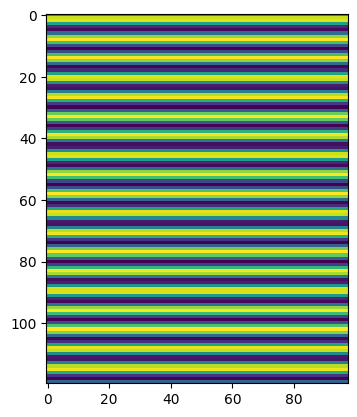

In [10]:
plt.imshow(embeddings[500, :, :])

In [16]:
import gc
gc.collect()

# Se stai usando più GPU, puoi farlo per una specifica
device = torch.device("cuda:0")  # Cambia a "cuda:1" se hai più GPU
with torch.cuda.device(device):
    torch.cuda.empty_cache()

# Opzionale: Resetta la memoria riservata
torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()


del optimizer
del model

NameError: name 'optimizer' is not defined

In [8]:
class SelfAttention(nn.Module):
    def __init__(self, channels, num_heads=1):
        """
        Parametri:
          - channels: numero di canali in input (e output)
          - num_heads: numero di teste per l'attenzione (default 1)
        """
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads

        self.norm = nn.GroupNorm(num_groups=1, num_channels=channels)

        self.q = nn.Conv2d(channels, channels, kernel_size=1)
        self.k = nn.Conv2d(channels, channels, kernel_size=1)
        self.v = nn.Conv2d(channels, channels, kernel_size=1)

        self.proj_out = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        """
        x: tensor di forma [B, C, H, W]
        """
        B, C, H, W = x.shape

        h = self.norm(x)

        q = self.q(h).reshape(B, self.num_heads, C // self.num_heads, H * W)
        k = self.k(h).reshape(B, self.num_heads, C // self.num_heads, H * W)
        v = self.v(h).reshape(B, self.num_heads, C // self.num_heads, H * W)

        scale = (C // self.num_heads) ** -0.5
        attn = torch.einsum('bhdn,bhdm->bhnm', q, k) * scale
        attn = torch.softmax(attn, dim=-1)

        out = torch.einsum('bhnm,bhdm->bhdn', attn, v)
        out = out.reshape(B, C, H, W)

        out = self.proj_out(out)
        return x + out


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class VarDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VarDoubleConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.r1 = nn.ReLU(inplace=True)
        self.conv_mu = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.conv_sigma = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.outconv = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.r2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.r1(x)
        mean = self.conv_mu(x)
        logvar = self.conv_sigma(x)

        z = torch.distributions.Normal(mean, torch.exp(logvar))
        
        x2 = self.outconv(z)
        x2 = self.bn2(x2)
        x2 = self.r2(x2)
        return x2, mean, logvar


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.down(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels=4, n_classes=3, bilinear=True, c=1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64 * c)
        self.down1 = Down(64 * c, 128 * c)
        self.down2 = Down(128 * c, 256 * c)
        self.down3 = Down(256 * c, 512 * c)
        factor = 2 if bilinear else 1
        self.down4 = Down(512 * c, 1024 * c // factor)
        
        self.up1 = Up(1024 * c, 512 * c // factor, bilinear)
        self.up2 = Up(512 * c, 256 * c // factor, bilinear)
        self.up3 = Up(256 * c, 128 * c // factor, bilinear)
        self.up4 = Up(128 * c, 64 * c, bilinear)
        self.outc = OutConv(64 * c, n_classes)


        # self.att0 = SelfAttention(64*c)
        self.att1 = SelfAttention(128*c)
        self.att2 = SelfAttention(256*c)
        self.attLAT1 = SelfAttention(1024*c // factor)

    def forward(self, image, embedding):
        x = torch.cat([image, embedding], dim=1)
        x1 = self.inc(x)

        x2 = self.down1(x1)
        x2 = self.att1(x2)

        x3 = self.down2(x2)
        x3 = self.att2(x3)

        x4 = self.down3(x3)
        x5 = self.down4(x4)


        # x5 = self.attLAT1(x5)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [10]:

model = UNet(4, 3, True, c=3)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model).cuda()

optimizer = Adam(model.parameters(), lr=0.0001)
model = model.to(device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)
mean_losses = []
criterion = nn.MSELoss()


Let's use 2 GPUs!
132880323


In [14]:
for epoch in range(3):
    total_loss = 0
    n_losses = len(data)
    mean_loss = 0
    for i, batch in enumerate(data):
        x = batch.to(device)
        t = torch.randint(0, T, (x.size(0),), device='cpu').long()
        alphas_bar_t = alphas_bar[t].view(-1, 1, 1, 1).to(device)
        noise = torch.randn_like(x) # epsilon nel paper
        noisy_images = (torch.sqrt(alphas_bar_t) * x + torch.sqrt(1 - alphas_bar_t) * noise).float()
        t_embs = embeddings[t]
        t_embs = t_embs.view(t_embs.shape[0], 1, t_embs.shape[1], t_embs.shape[2]).to(device)
        # y, mean, logvar = model(noisy_images, t_embs)
        y = model(noisy_images, t_embs)


        optimizer.zero_grad()
        # loss = criterion(noise, y, mean, logvar)
        loss = criterion(noise, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if i % 100 == 0:
            print(f'step {i} - loss --- {loss.item()}')
    mean_loss = total_loss/n_losses
    print(epoch, mean_loss)
    mean_losses.append(mean_loss)
    #print(epoch, loss.item())

step 0 - loss --- 0.021734261885285378
step 100 - loss --- 0.019134368747472763
step 200 - loss --- 0.03256483003497124


KeyboardInterrupt: 

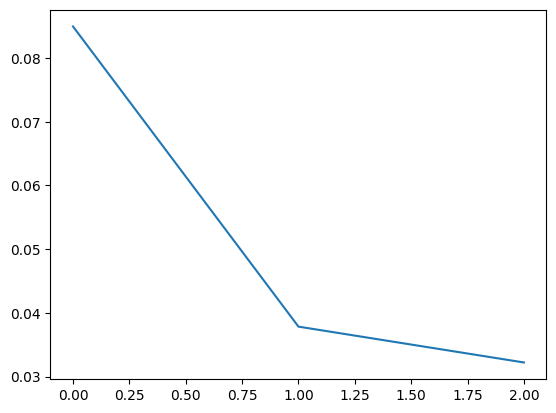

In [14]:
plt.plot(mean_losses)

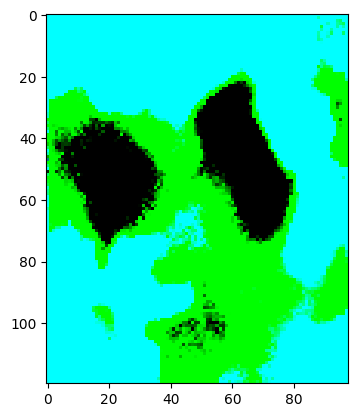

In [13]:
dim1 = H
dim2 = W
with torch.no_grad():
    x = torch.randn((1, 3, dim1, dim2), device=device)
    
    for t in reversed(range(1, T)):
        # Get the time embedding for step t
        time_emb = embeddings[t].view(1, 1, dim1, dim2).to(device)
        
        # Predict the noise component for the current sample and timestep
        predicted_noise = model(x, time_emb)
        
        # Get current parameters from the noise schedule:
        alpha_t = alphas[t]            # scalar or tensor of shape [1] 
        alpha_bar_t = alphas_bar[t]      # cumulative product up to t
        beta_t = betas[t]                # variance for step t
        
        # Compute the reverse process mean
        x_mean = (1.0 / torch.sqrt(alpha_t)) * (
                  x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * predicted_noise
                 )        
        #print(x.mean())
        if t > 1:
            # Add noise for stochasticity in reverse process:
            noise = torch.randn_like(x)
            sigma_t = torch.sqrt(beta_t)
            x = x_mean + sigma_t * noise
        else:
            x = x_mean  # final step, no noise added

with torch.no_grad():
    plt.imshow(x[0].cpu().numpy().transpose(1, 2, 0))
    plt.show()

In [ ]:
print(x.mean())

In [15]:
torch.save(model.state_dict(), "Celeb1.pt")

In [ ]:
model.load_state_dict(torch.load('/kaggle/working/Sim3.pt'))